In [1]:
from bertopic import BERTopic
import numpy as np
import pandas as pd
from transformers import pipeline
from bertopic.representation import TextGeneration
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import datetime
import nltk
from nltk.corpus import stopwords
import logging
import os
from dotenv import load_dotenv
from umap import UMAP
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
import openai
import spacy
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech
from sklearn.metrics import silhouette_score

load_dotenv()
OPENAI_KEY = os.getenv("OPENAI_KEY")

/home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
# Universal Figure Auto-Save Function
import os
from datetime import datetime
import plotly.graph_objects as go

def auto_save_figure(fig, figure_name, save_formats=['png', 'html'], 
                    width=1000, height=700, scale=2, output_dir="../../outputs/plots"):
    """
    Automatically save any Plotly figure to disk with multiple formats and timestamp
    
    Parameters:
    -----------
    fig : plotly.graph_objects.Figure
        The Plotly figure to save
    figure_name : str
        Descriptive name for the figure (will be used in filename)
    save_formats : list
        List of formats to save ['png', 'html', 'pdf', 'svg', 'jpeg']
    width : int
        Width of the saved image
    height : int
        Height of the saved image
    scale : int
        Scale factor for image resolution (higher = better quality)
    output_dir : str
        Directory to save the figures
    
    Returns:
    --------
    dict : Dictionary with saved file paths
    """
    if fig is None:
        print(f"❌ No figure provided for '{figure_name}'")
        return {}
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Generate timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    saved_files = {}
    
    for format_type in save_formats:
        # Clean figure name for filename (remove spaces, special chars)
        clean_name = "".join(c for c in figure_name if c.isalnum() or c in (' ', '-', '_')).rstrip()
        clean_name = clean_name.replace(' ', '_').lower()
        
        filename = f"{timestamp}_{clean_name}.{format_type}"
        filepath = os.path.join(output_dir, filename)
        
        try:
            if format_type == 'html':
                # Save as interactive HTML
                fig.write_html(filepath)
                print(f"📊 Saved {figure_name} as HTML: {filename}")
                
            elif format_type in ['png', 'pdf', 'svg', 'jpeg']:
                # Save as static image (requires kaleido)
                fig.write_image(
                    filepath,
                    width=width,
                    height=height,
                    scale=scale,
                    format=format_type
                )
                print(f"🖼️  Saved {figure_name} as {format_type.upper()}: {filename}")
            
            saved_files[format_type] = os.path.abspath(filepath)
            
        except Exception as e:
            print(f"❌ Error saving {figure_name} as {format_type}: {e}")
    
    if saved_files:
        print(f"✅ Total saved: {len(saved_files)} file(s) for '{figure_name}'")
        print(f"📁 Location: {os.path.abspath(output_dir)}")
        print("-" * 60)
    
    return saved_files

# Enhanced wrapper function for BERTopic visualizations
def save_bertopic_figure(fig, viz_type, group_name="Female_ADHD", **kwargs):
    """
    Specialized function for saving BERTopic visualizations with consistent naming
    
    Parameters:
    -----------
    fig : plotly.graph_objects.Figure
        The BERTopic figure to save
    viz_type : str
        Type of visualization ('topics', 'heatmap', 'hierarchy', 'barchart', 'document_map', etc.)
    group_name : str
        Name of the group being analyzed
    **kwargs : additional arguments passed to auto_save_figure
    """
    figure_name = f"bertopic_{viz_type}_{group_name}"
    return auto_save_figure(fig, figure_name, **kwargs)

print("✅ Auto-save functions loaded!")
print("📋 Usage:")
print("   auto_save_figure(fig, 'description')  # Basic usage")
print("   save_bertopic_figure(fig, 'topics')   # For BERTopic visualizations")
print("   Default formats: PNG + HTML")
print("   Default location: ../../outputs/plots/")
print("-" * 60)

✅ Auto-save functions loaded!
📋 Usage:
   auto_save_figure(fig, 'description')  # Basic usage
   save_bertopic_figure(fig, 'topics')   # For BERTopic visualizations
   Default formats: PNG + HTML
   Default location: ../../outputs/plots/
------------------------------------------------------------


In [2]:
topic_df = pd.read_pickle("../../data/adhd-beliefs-pt/adhd-beliefs-pt-embeddings-serafim-bertopic.pkl")
topic_df

,datetime,sex,adhd_diagnosis,age,education,occupation,dialect,forgetting_objects,forgetting_responsabilities,emotion_management,...,need_fast_talk_interest,need_fast_talk_information,speaking_before_thinking,something_to_add,something_to_add_timid,something_to_add_impulsive,question,response,response_embedding,group
1,2025-03-30T16:29:47+02:00,Feminino,Não tenho,22,Licenciatura,Estudante,Português de Portugal,3,3,4,...,1,1,3,4,4,2,special_interest,"Adoro cozinhar, porque sinto que é a forma ide...","[-0.0066892994, -0.008711162, 0.020823173, -0....",Female_noADHD
3,2025-03-31T12:08:00+02:00,Feminino,Não tenho,23,Mestrado,Trabalhador-estudante,Português de Portugal,2,1,4,...,1,1,4,4,4,2,special_interest,Gosto de ver séries porque relatam relações sa...,"[0.011201556, -0.016555935, 0.055444784, 0.028...",Female_noADHD
8,2025-03-31T12:55:43+02:00,Feminino,Não tenho,19,Licenciatura,Estudante,Português de Portugal,3,2,2,...,4,4,2,4,3,3,special_interest,Campos de ferias. Temos que criar o campo todo...,"[-0.010825634, -0.02388897, -0.013832388, -0.0...",Female_noADHD
14,2025-03-31T13:54:40+02:00,Feminino,Não tenho,25,Mestrado,Trabalhador,Português de Portugal,4,3,4,...,2,3,3,5,4,4,special_interest,"Taylor Swift, amo o seu liricismo e a maneira ...","[-0.029966783, -0.030345816, 0.014844258, 0.01...",Female_noADHD
15,2025-03-31T13:58:15+02:00,Feminino,Suspeito que tenho,25,Licenciatura,Trabalhador,Português de Portugal,4,2,5,...,2,2,3,5,5,3,special_interest,Historia da arte \nÉ só tão interessante. Para...,"[-0.026616445, -0.021927394, 0.014119625, 0.01...",Female_noADHD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,2025-06-07T16:05:17+02:00,Feminino,"Sim, diagnosticado",51,Mestrado,Trabalhador-estudante,Português de Portugal,4,2,5,...,3,2,4,4,5,5,empty_sheet,"O ponto em que sociedade se está a tornar,: eg...","[-0.019272415, -0.014781286, 0.036758002, 0.00...",Female_ADHD
296,2025-06-07T17:23:10+02:00,Feminino,"Sim, diagnosticado",36,Pós-Graduação,Estudante,Português de Portugal,5,3,3,...,2,3,3,4,3,3,empty_sheet,Gostava que não dissessem : toda a gente tem p...,"[-0.05752369, 0.0008796515, -0.011525935, -0.0...",Female_ADHD
307,2025-06-10T16:58:08+02:00,Feminino,"Sim, diagnosticado",19,Ensino secundário,Trabalhador-estudante,Português de Portugal,4,2,4,...,4,4,4,5,4,4,empty_sheet,Não sei explicar o que se anda a passar comigo...,"[-0.02658491, -0.011627352, 0.029701555, -0.01...",Female_ADHD
308,2025-06-10T17:45:28+02:00,Masculino,"Sim, diagnosticado",19,Ensino secundário,Estudante,Português de Portugal,2,3,4,...,1,1,3,4,2,2,empty_sheet,"De momento, na minha cabeça, só rumino sobre o...","[-0.015350613, -0.020685123, 0.0079341745, -0....",Male_ADHD


In [3]:
def load_bert_model(path):
    return BERTopic.load(path, embedding_model=SentenceTransformer("PORTULAN/serafim-900m-portuguese-pt-sentence-encoder"))

In [4]:
folders = [name for name in os.listdir("../../data/adhd-beliefs-pt/bertopic_models/") if os.path.isdir(os.path.join("../../data/adhd-beliefs-pt/bertopic_models/", name))]
folders

['Others_20250814_014028',
 'Male_ADHD_20250814_014705',
 'Male_noADHD_20250814_014720',
 'Female_noADHD_20250814_014609',
 'Female_ADHD_20250814_013830']

## Female ADHD

In [5]:
topic_df = topic_df[topic_df["group"] == "Female_ADHD"]

In [6]:
folder = next(f for f in folders if f.startswith("Female_ADHD"))
print(f"Loading model for group: {folder}")
path = f"../../data/adhd-beliefs-pt/bertopic_models/{folder}/"
topic_model = load_bert_model(path)

Loading model for group: Female_ADHD_20250814_013830


In [7]:
topic_model.get_topic_info()

,Topic,Count,Name,CustomName,Representation,KeyBERT,OpenAI,MMR,POS,Representative_Docs
0,-1,10,-1_percebi_dia_comecei_cérebro,Outlier Topic,"[percebi, dia, comecei, cérebro, hoje dia, faz...","[pânico, ansiedade, acordei, aborrecimento, do...",[tópico: Anos de luta e autodescoberta],"[comecei, cérebro, hoje dia, nunca, depressão,...","[dia, cérebro, interesse, resto, depressão, cr...",NaN
1,0,10,0_phda_pessoas_lá_vida,tópico: Desafios da Neurodiversidade e Saúde,"[phda, pessoas, lá, vida, onde, continua, tão,...","[pânico, aborrecimento, diagnóstico, muitas ve...",[tópico: Desafios da Neurodiversidade e Saúde],"[phda, pessoas, viver, vezes, comer, pão, falt...","[phda, pessoas, vida, vezes, pão, diferente, f...",NaN
2,1,8,1_comigo_amigos_anos_nunca,tópico: Memórias de exclusão social,"[comigo, amigos, anos, nunca, pessoas, mãe, ne...","[tornei, comigo própria, senti, mim, preocupad...",[tópico: Memórias de exclusão social],"[amigos, anos, nunca, mãe, falar, ninguém, mem...","[comigo, amigos, anos, pessoas, mãe, vida, pes...",NaN
3,2,7,2_tudo_tão_mundo_interesse especial,tópico: Interesses e Reflexões Pessoais,"[tudo, tão, mundo, interesse especial, especia...","[especiais, interesse especial, interesses esp...",[tópico: Interesses e Reflexões Pessoais],"[nada, áreas, difícil porque, novas, pergunta ...","[mundo, especial, interesse, áreas, ideia, nov...",NaN
4,3,6,3_ainda_acordei_ir_gostava,tópico: Reflexões sobre o cotidiano,"[ainda, acordei, ir, gostava, dia, hoje, casa,...","[hoje acordei, acordei, cansada, tornei, dormi...",[tópico: Reflexões sobre o cotidiano],"[acordei, gostava, tarde, almoço, cansada, nin...","[dia, casa, tarde, meio, almoço, semana, cansa...",NaN
5,4,5,4_mental_saúde_sempre_ajudar,tópico: Saúde Mental e Justiça Social,"[mental, saúde, sempre, ajudar, psicologia, mo...","[psicologia, mental, sentimentos, pensamentos,...",[tópico: Saúde Mental e Justiça Social],"[mental, saúde, sempre, ajudar, psicologia, pe...","[mental, saúde, infantil, boa, sentimentos, pe...",NaN
6,5,4,5_consigo_diário_escrever_fazer,tópico: Dificuldades em escrever e correr,"[consigo, diário, escrever, fazer, dar, correr...","[fazer, correr, escrever, consigo, gosto, , , ...",[tópico: Dificuldades em escrever e correr],"[consigo, diário, escrever, fazer, dar, correr...","[diário, , , , , , , , , ]",NaN
7,6,3,6_serem_motivos_verdadeiramente_tendência,tópico: Relação e tratamento de animais,"[serem, motivos, verdadeiramente, tendência, c...","[terem, serem, adoro, coisas, têm, gato, filho...",[tópico: Relação e tratamento de animais],"[tendência, comportamento, sociedade, problema...","[tendência, motivos, sociedade, comportamento,...",NaN
8,7,3,7_base_pai_acordar_clara,tópico: Momentos de felicidade cotidiana,"[base, pai, acordar, clara, faço, café, faz, d...","[fiz, acordei, faço, apeteceu, acabei, hoje ac...",[tópico: Momentos de felicidade cotidiana],"[acordar, café, horas, fazer, almoçar, apetece...","[pai, base, clara, café, horas, bebida, chamad...",NaN
9,8,3,8_tempo_trabalho_montes_fazer,tópico: Sobrecarga e Procrastinação Acadêmica,"[tempo, trabalho, montes, fazer, cansada, casa...","[comigo própria, mim, trabalhar ainda, quero d...",[tópico: Sobrecarga e Procrastinação Acadêmica],"[fazer, coisas, constantemente, comigo própria...","[tempo, trabalho, montes, cansada, coisas, cas...",NaN


In [8]:
texts = topic_df["response"].tolist()
print(f"Number of texts: {len(texts)}")
print(f"Number of topics: {len(topic_model.topics_)}")


# The model might have been trained on different data
# Let's check if we need to use the original training data
# or if we need to fit_transform the current texts
if len(texts) != len(topic_model.topics_):
    print("Length mismatch detected. The model topics were from different training data.")
    print("Using topic info instead of document info.")
    # We can still use get_topic_info() which works fine
    display(topic_model.get_topic_info())
else:
    display(topic_model.get_document_info(texts))

Number of texts: 65
Number of topics: 65


,Document,Topic,Name,CustomName,Representation,KeyBERT,OpenAI,MMR,POS,Representative_Docs,Top_n_words,Representative_document
0,"Pedras, necrópoles, minerais, música, cinema, ...",2,2_tudo_tão_mundo_interesse especial,tópico: Interesses e Reflexões Pessoais,"[tudo, tão, mundo, interesse especial, especia...","[especiais, interesse especial, interesses esp...",[tópico: Interesses e Reflexões Pessoais],"[nada, áreas, difícil porque, novas, pergunta ...","[mundo, especial, interesse, áreas, ideia, nov...",NaN,tudo - tão - mundo - interesse especial - espe...,False
1,Um dos meus interesses especiais é skincare co...,9,9_adoro_comigo mesma_disso_especiais,tópico: Interesses em saúde e skincare,"[adoro, comigo mesma, disso, especiais, intere...","[interesses especiais, psicologia, mental, mim...",[tópico: Interesses em saúde e skincare],"[comigo mesma, interesses especiais, saber, in...","[especiais, tanto, causa, difícil, facto, saúd...",NaN,adoro - comigo mesma - disso - especiais - int...,False
2,Pergunta difícil porque tenho vários e eles vã...,2,2_tudo_tão_mundo_interesse especial,tópico: Interesses e Reflexões Pessoais,"[tudo, tão, mundo, interesse especial, especia...","[especiais, interesse especial, interesses esp...",[tópico: Interesses e Reflexões Pessoais],"[nada, áreas, difícil porque, novas, pergunta ...","[mundo, especial, interesse, áreas, ideia, nov...",NaN,tudo - tão - mundo - interesse especial - espe...,False
3,"Animais, sempre amei animais e é a minha maior...",6,6_serem_motivos_verdadeiramente_tendência,tópico: Relação e tratamento de animais,"[serem, motivos, verdadeiramente, tendência, c...","[terem, serem, adoro, coisas, têm, gato, filho...",[tópico: Relação e tratamento de animais],"[tendência, comportamento, sociedade, problema...","[tendência, motivos, sociedade, comportamento,...",NaN,serem - motivos - verdadeiramente - tendência ...,False
4,"Adoro ler, embora agora esteja sem muita vonta...",10,10_ler_quero dormir_ideias_novas,tópico: Leitura e sonhos criativos,"[ler, quero dormir, ideias, novas, vontade, re...","[quero dormir, ler, vejo, vontade, dormir, que...",[tópico: Leitura e sonhos criativos],"[ler, quero dormir, ideias, vontade, vejo, que...","[vontade, novas, ideias, realidade, mundo, miú...",NaN,ler - quero dormir - ideias - novas - vontade ...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
60,A PHDA influencia tudo na minha vida. Mas prin...,0,0_phda_pessoas_lá_vida,tópico: Desafios da Neurodiversidade e Saúde,"[phda, pessoas, lá, vida, onde, continua, tão,...","[pânico, aborrecimento, diagnóstico, muitas ve...",[tópico: Desafios da Neurodiversidade e Saúde],"[phda, pessoas, viver, vezes, comer, pão, falt...","[phda, pessoas, vida, vezes, pão, diferente, f...",NaN,phda - pessoas - lá - vida - onde - continua -...,False
61,"""O serial killer e o bode espiatorio"". O pânic...",0,0_phda_pessoas_lá_vida,tópico: Desafios da Neurodiversidade e Saúde,"[phda, pessoas, lá, vida, onde, continua, tão,...","[pânico, aborrecimento, diagnóstico, muitas ve...",[tópico: Desafios da Neurodiversidade e Saúde],"[phda, pessoas, viver, vezes, comer, pão, falt...","[phda, pessoas, vida, vezes, pão, diferente, f...",NaN,phda - pessoas - lá - vida - onde - continua -...,False
62,"O ponto em que sociedade se está a tornar,: eg...",0,0_phda_pessoas_lá_vida,tópico: Desafios da Neurodiversidade e Saúde,"[phda, pessoas, lá, vida, onde, continua, tão,...","[pânico, aborrecimento, diagnóstico, muitas ve...",[tópico: Desafios da Neurodiversidade e Saúde],"[phda, pessoas, viver, vezes, comer, pão, falt...","[phda, pessoas, vida, vezes, pão, diferente, f...",NaN,phda - pessoas - lá - vida - onde - continua -...,False
63,Gostava que não dissessem : toda a gente tem p...,0,0_phda_pessoas_lá_vida,tópico: Desafios da Neurodiversidade e Saúde,"[phda, pessoas, lá, vida, onde, continua, tão,...","[pânico, aborrecimento, diagnóstico, muitas ve...",[tópico: Desafios da Neurodiversidade e Saúde],"[phda, pessoas, viver, vezes

In [ ]:
# Visualize topics and auto-save
fig_topics = topic_model.visualize_topics(custom_labels=True)
save_bertopic_figure(fig_topics, 'topics')
fig_topics

🖼️  Saved bertopic_topics_Female_ADHD as PNG: 20250814_033341_bertopic_topics_female_adhd.png
📊 Saved bertopic_topics_Female_ADHD as HTML: 20250814_033341_bertopic_topics_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/plots
------------------------------------------------------------


In [41]:
# Visualize heatmap and auto-save
fig_heatmap = topic_model.visualize_heatmap(custom_labels=True)
save_bertopic_figure(fig_heatmap, 'heatmap')
fig_heatmap

🖼️  Saved bertopic_heatmap_Female_ADHD as PNG: 20250814_033348_bertopic_heatmap_female_adhd.png
📊 Saved bertopic_heatmap_Female_ADHD as HTML: 20250814_033348_bertopic_heatmap_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/plots
------------------------------------------------------------


In [42]:
# Visualize topics per class and auto-save
topics_per_class = topic_model.topics_per_class(texts, classes=classes)
fig_topics_per_class = topic_model.visualize_topics_per_class(topics_per_class, custom_labels=True)
save_bertopic_figure(fig_topics_per_class, 'topics_per_class')
fig_topics_per_class

4it [00:00, 145.44it/s]



🖼️  Saved bertopic_topics_per_class_Female_ADHD as PNG: 20250814_033527_bertopic_topics_per_class_female_adhd.png
📊 Saved bertopic_topics_per_class_Female_ADHD as HTML: 20250814_033527_bertopic_topics_per_class_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/plots
------------------------------------------------------------


❌ Error saving bertopic_document_datamap_Female_ADHD as png: 'Figure' object has no attribute 'write_image'
❌ Error saving bertopic_document_datamap_Female_ADHD as html: 'Figure' object has no attribute 'write_html'


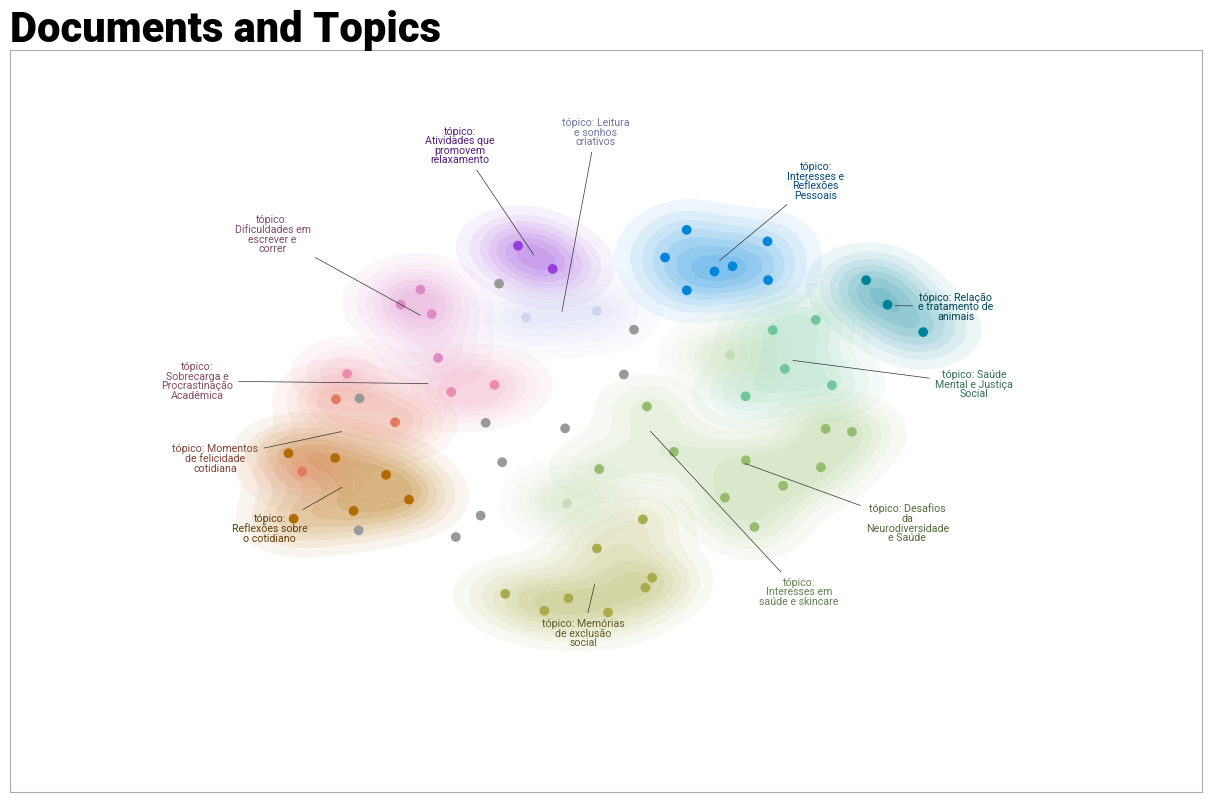

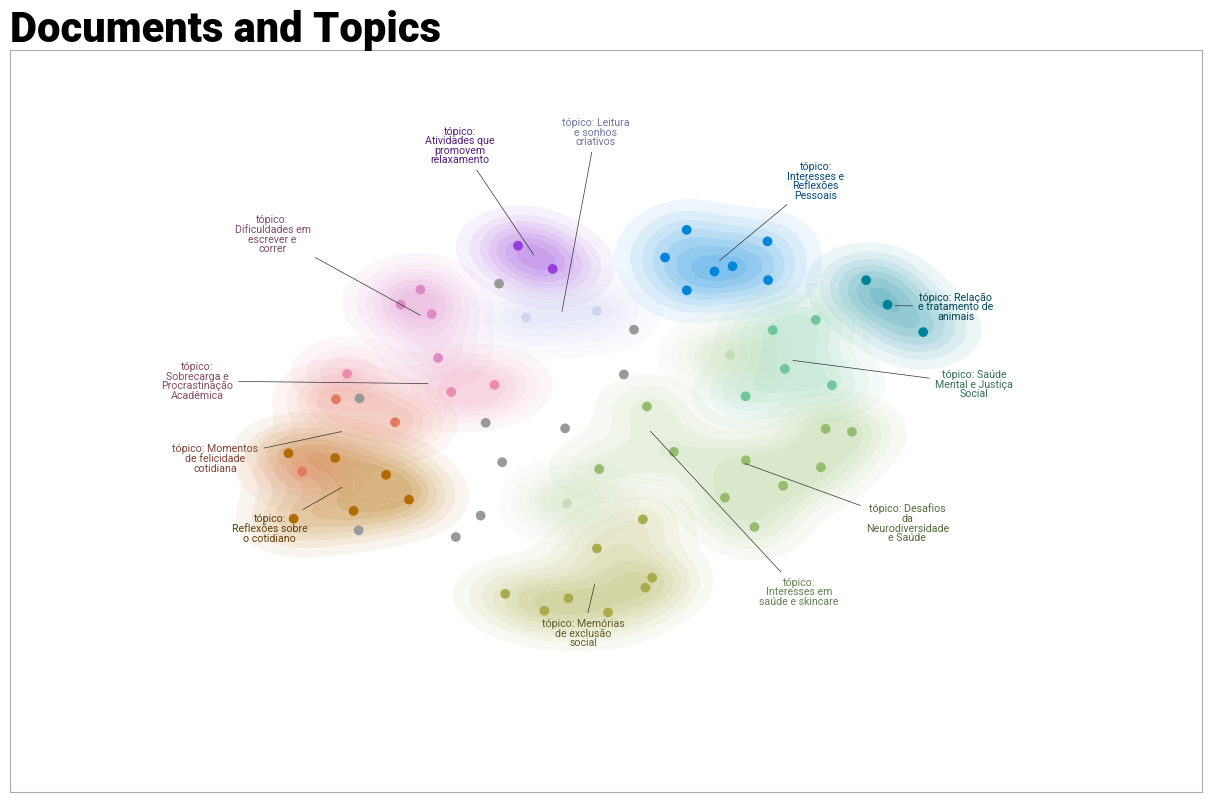

In [43]:
# Visualize document datamap and auto-save
fig_document_datamap = topic_model.visualize_document_datamap(texts, embeddings=embeddings, custom_labels=True)
save_bertopic_figure(fig_document_datamap, 'document_datamap')
fig_document_datamap

In [ ]:
# Translation approach 1: Using deep-translator (simple and reliable)
from deep_translator import GoogleTranslator

def translate_topic_words(topic_model, target_language='en', source_language='pt'):
    """
    Translate topic words from Portuguese to English
    """
    translator = GoogleTranslator(source=source_language, target=target_language)
    
    # Hardcoded translations for specific terms
    hardcoded_translations = {
        'phda': 'adhd',
        'PHDA': 'ADHD',
        'Phda': 'ADHD'
    }
    
    topics_dict = topic_model.get_topics()
    translated_topics = {}
    
    for topic_id, words_scores in topics_dict.items():
        if topic_id == -1:  # Skip noise topic
            continue
            
        # Extract just the words (first element of each tuple)
        words = [word for word, score in words_scores]
        
        # Translate words
        try:
            translated_words = []
            for word in words:
                # Check if we have a hardcoded translation first
                if word in hardcoded_translations:
                    translated = hardcoded_translations[word]
                else:
                    translated = translator.translate(word)
                translated_words.append(translated)
            
            # Keep the same scores but with translated words
            translated_topic = [(translated_words[i], score) for i, (word, score) in enumerate(words_scores)]
            translated_topics[topic_id] = translated_topic
            
        except Exception as e:
            print(f"Error translating topic {topic_id}: {e}")
            # Keep original if translation fails
            translated_topics[topic_id] = words_scores
    
    return translated_topics

# Get translated topics
print("Translating topic words to English...")
translated_topics = translate_topic_words(topic_model)

# Display translated topics
print("\nTranslated Topics (Portuguese → English):")
print("="*60)
for topic_id, words_scores in translated_topics.items():
    words = [word for word, score in words_scores[:5]]  # Top 5 words
    print(f"Topic {topic_id}: {', '.join(words)}")
print("="*60)

Translating topic words to English...

Translated Topics (Portuguese → English):
Topic 0: adhd, people, there, life, where
Topic 1: with me, friends, years, never, people
Topic 2: all, so, world, special interest, special
Topic 3: yet, I woke up, go, liked, day
Topic 4: mental, health, always, to help, psychology
Topic 5: with you, daily, to write, to do, give
Topic 6: be, reasons, truly, trend, behavior
Topic 7: base, father, to wake up, clear, I make
Topic 8: time, work, hills, to do, tired
Topic 9: I adore, myself, from that, special, special interests
Topic 10: to read, I want to sleep, ideas, new, willing
Topic 11: focused, normally, think, just, moment

Translated Topics (Portuguese → English):
Topic 0: adhd, people, there, life, where
Topic 1: with me, friends, years, never, people
Topic 2: all, so, world, special interest, special
Topic 3: yet, I woke up, go, liked, day
Topic 4: mental, health, always, to help, psychology
Topic 5: with you, daily, to write, to do, give
Topic 6:

In [44]:
def visualize_barchart_translated_fixed(topic_model, translated_topics, topics=None, top_k_topics=6, n_words=5, 
                                        custom_labels=True, title="<b>Topic Word Scores</b>", 
                                        width=800, height=600):
    """
    Create a bar chart visualization in the exact same style as BERTopic's visualize_barchart
    but with translated words - FIXED VERSION for proper label mapping
    """
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    # Get topic information and prepare data
    topic_info = topic_model.get_topic_info()
    
    # Select topics to show (excluding outliers/noise topic -1)
    if topics is None:
        # Get top k topics by size (excluding noise topic -1)
        selected_topics = topic_info[topic_info['Topic'] != -1].head(top_k_topics)['Topic'].tolist()
    else:
        # Filter out -1 from provided topics
        selected_topics = [t for t in topics if t != -1]
    
    # Filter selected_topics to only include those that exist in translated_topics
    available_topics = [topic_id for topic_id in selected_topics if topic_id in translated_topics]
    
    print(f"DEBUG: Available topics for plotting: {available_topics}")
    
    # Create subplot titles ONLY for the topics that will actually be plotted
    # The key fix: properly map topic IDs to their position in the topic_info dataframe
    subplot_titles = []
    for topic_id in available_topics:
        if custom_labels and hasattr(topic_model, 'custom_labels_') and topic_model.custom_labels_:
            # Find the topic in topic_info and get its custom label
            topic_row = topic_info[topic_info['Topic'] == topic_id]
            if not topic_row.empty and 'CustomName' in topic_row.columns:
                topic_label = topic_row.iloc[0]['CustomName']
            elif not topic_row.empty and 'Name' in topic_row.columns:
                topic_label = topic_row.iloc[0]['Name']
            else:
                # Fallback: try to get from custom_labels_ array using topic position
                # Find the position of this topic in the topic_info (excluding outliers)
                non_outlier_topics = topic_info[topic_info['Topic'] != -1]
                topic_position = None
                for idx, row in non_outlier_topics.iterrows():
                    if row['Topic'] == topic_id:
                        topic_position = list(non_outlier_topics.index).index(idx)
                        break
                
                if topic_position is not None and topic_position < len(topic_model.custom_labels_):
                    topic_label = topic_model.custom_labels_[topic_position]
                else:
                    topic_label = f"Topic {topic_id}"
        else:
            topic_label = f"Topic {topic_id}"
        
        print(f"DEBUG: Topic {topic_id} -> Label: {topic_label}")
        subplot_titles.append(topic_label)
    
    # Prepare subplot structure - one row per topic that will actually be plotted
    n_topics = len(available_topics)
    if n_topics == 0:
        print("No topics available for plotting")
        return None
        
    fig = make_subplots(
        rows=n_topics, 
        cols=1,
        shared_xaxes=False,
        vertical_spacing=0.08,
        subplot_titles=subplot_titles
    )
    
    # Color scheme similar to BERTopic
    colors = ["#D55E00", "#0072B2", "#CC79A7", "#E69F00", "#56B4E9", "#009E73", "#F0E442"]
    
    # Process each topic that will actually be plotted
    for i, topic_id in enumerate(available_topics):
        # Get translated words and scores
        words_scores = translated_topics[topic_id][:n_words]
        words = [word for word, score in words_scores]
        scores = [score for word, score in words_scores]
        
        # Reverse order for proper display (highest scores at top)
        words = words[::-1]
        scores = scores[::-1]
        
        # Create horizontal bar trace
        trace = go.Bar(
            y=words,
            x=scores,
            orientation='h',
            marker=dict(
                color=colors[i % len(colors)],
                line=dict(color='rgba(0,0,0,0.3)', width=0.5)
            ),
            text=[f"{score:.3f}" for score in scores],
            textposition='outside',
            textfont=dict(size=11),
            hovertemplate='<b>%{y}</b><br>Score: %{x:.3f}<extra></extra>',
            showlegend=False,
            name=f"Topic {topic_id}"
        )
        
        fig.add_trace(trace, row=i+1, col=1)
    
    # Update layout to match BERTopic style
    fig.update_layout(
        title=dict(
            text=title,
            x=0.5,
            xanchor="center",
            font=dict(size=16, color="black")
        ),
        height=height,
        width=width,
        plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(color="black", size=11),
        margin=dict(l=10, r=10, t=60, b=10)
    )
    
    # Update axes for each subplot
    for i in range(n_topics):
        # X-axis
        fig.update_xaxes(
            showgrid=True,
            gridwidth=1,
            gridcolor='rgba(0,0,0,0.1)',
            zeroline=True,
            zerolinewidth=1,
            zerolinecolor='rgba(0,0,0,0.3)',
            showline=True,
            linewidth=1,
            linecolor='black',
            row=i+1, col=1
        )
        
        # Y-axis
        fig.update_yaxes(
            showgrid=False,
            showline=True,
            linewidth=1,
            linecolor='black',
            tickfont=dict(size=10),
            row=i+1, col=1
        )
    
    # Update annotation style for subplot titles
    fig.update_annotations(font_size=12, font_color="black")
    
    return fig

# Create the FIXED BERTopic-style visualization with translated words
print("Creating FIXED BERTopic-style visualization with properly aligned titles...")
fig_bertopic_style_fixed = visualize_barchart_translated_fixed(
    topic_model, 
    translated_topics, 
    top_k_topics=6, 
    n_words=5,
    custom_labels=True,
    width=1000,
    height=700
)
    
if fig_bertopic_style_fixed:
    # Auto-save the translated barchart
    save_bertopic_figure(fig_bertopic_style_fixed, 'translated_barchart')
    fig_bertopic_style_fixed.show()
else:
    print("No valid topics to display")

Creating FIXED BERTopic-style visualization with properly aligned titles...
DEBUG: Available topics for plotting: [0, 1, 2, 3, 4, 5]
DEBUG: Topic 0 -> Label: tópico: Desafios da Neurodiversidade e Saúde
DEBUG: Topic 1 -> Label: tópico: Memórias de exclusão social
DEBUG: Topic 2 -> Label: tópico: Interesses e Reflexões Pessoais
DEBUG: Topic 3 -> Label: tópico: Reflexões sobre o cotidiano
DEBUG: Topic 4 -> Label: tópico: Saúde Mental e Justiça Social
DEBUG: Topic 5 -> Label: tópico: Dificuldades em escrever e correr
🖼️  Saved bertopic_translated_barchart_Female_ADHD as PNG: 20250814_033637_bertopic_translated_barchart_female_adhd.png
📊 Saved bertopic_translated_barchart_Female_ADHD as HTML: 20250814_033637_bertopic_translated_barchart_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_translated_barchart_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/plots
------------------------------------------------------------
🖼️  Saved bertopic

In [37]:
# Save the plot as PNG file
import os
from datetime import datetime

# Create outputs directory if it doesn't exist
output_dir = "../../outputs/plots"
os.makedirs(output_dir, exist_ok=True)

# Generate filename with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"bertopic_translated_barchart_{timestamp}.png"
filepath = os.path.join(output_dir, filename)

# Save the figure as PNG
if fig_bertopic_style_fixed:
    try:
        fig_bertopic_style_fixed.write_image(
            filepath,
            width=1000,
            height=700,
            scale=2,  # Higher resolution (2x)
            format="png"
        )
        print(f"✅ Plot saved successfully as: {filepath}")
        print(f"📁 Full path: {os.path.abspath(filepath)}")
    except Exception as e:
        print(f"❌ Error saving plot: {e}")
        print("💡 Make sure you have 'kaleido' installed: uv add kaleido")
else:
    print("❌ No figure to save. Please run the visualization cell first.")

✅ Plot saved successfully as: ../../outputs/plots/bertopic_translated_barchart_20250814_032913.png
📁 Full path: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/plots/bertopic_translated_barchart_20250814_032913.png


In [45]:
# Visualize hierarchy and auto-save
hierarchical_topics = topic_model.hierarchical_topics(texts)
fig_hierarchy = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, custom_labels=True)
save_bertopic_figure(fig_hierarchy, 'hierarchy')
fig_hierarchy

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:00<00:00, 407.57it/s]


🖼️  Saved bertopic_hierarchy_Female_ADHD as PNG: 20250814_033722_bertopic_hierarchy_female_adhd.png
📊 Saved bertopic_hierarchy_Female_ADHD as HTML: 20250814_033722_bertopic_hierarchy_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/plots
------------------------------------------------------------


### evaluation of the BERTopic model

In [46]:
umap_embeddings = topic_model.umap_model.transform(embeddings)
document_topics = topic_model.topics_  # Get document-topic assignments, not topic definitions
indices = [index for index, topic in enumerate(document_topics) if topic != -1]
X = umap_embeddings[np.array(indices)]
labels = [topic for index, topic in enumerate(document_topics) if topic != -1]

# Calculate silhouette score
silhouette_score(X, labels)

0.04883626848459244

## 📁 Auto-Save Functions - Usage Guide

All figures in this notebook are now automatically saved when created! Here's how the auto-save system works:

### 🔧 **Automatic Saving**
- **Format**: PNG + HTML (both formats saved automatically)
- **Location**: `../../outputs/plots/`
- **Naming**: Timestamped files (e.g., `20250814_033341_bertopic_topics_female_adhd.png`)
- **Quality**: High resolution (2x scale for crisp images)

### 📊 **For BERTopic Visualizations**
All BERTopic visualizations now automatically save using:
```python
# Pattern used in all BERTopic cells:
fig_name = topic_model.visualize_[method](custom_labels=True)
save_bertopic_figure(fig_name, 'method_name')
fig_name  # Display the figure
```

### 🎨 **For Custom Figures**
If you create any custom Plotly figures, use:
```python
# Basic usage
auto_save_figure(your_figure, 'descriptive_name')

# Advanced usage with custom settings
auto_save_figure(
    your_figure, 
    'descriptive_name',
    save_formats=['png', 'html', 'pdf'],  # Multiple formats
    width=1200, 
    height=800,
    scale=3  # Higher resolution
)
```

### 📋 **Available Formats**
- `'png'` - Static image (default)
- `'html'` - Interactive web version (default) 
- `'pdf'` - PDF document
- `'svg'` - Scalable vector graphics
- `'jpeg'` - JPEG image

### ✅ **Benefits**
- **No manual saving needed** - happens automatically
- **Multiple formats** - both static and interactive versions
- **Organized storage** - all plots in one location
- **Version control** - timestamped filenames prevent overwrites
- **High quality** - optimized resolution for publications